In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import curve_fit
from typing import Dict, List, Tuple
plt.style.use("bmh")

In [3]:
def cargar_datos(file_name : str, pow_measure = False) -> list:

    # Cargamos los datos
    with open(file_name, "rb") as f:
        dic = pickle.load(f)
    # Hago una lista con los valores de offset que alimentamos con el generador de funciones
    offs_values_keys = list(dic.keys())
    # Valores de corriente en mA
    corr_values = [np.mean(dic[offset]["V_2"])*1000 for offset in offs_values_keys]
    # Verdaderos valores de continua
    offs_true_values = [np.mean(dic[offset]["V_1"]) for offset in offs_values_keys]
    # Le sacamos la "V" a las keys
    offs_values = [float(offset[:-1]) for offset in offs_values_keys]

    # Creamos una lista para guardar todos los datos que nos interesan
    lista_mediciones = [offs_values, offs_true_values, corr_values]

    # Mediciones de la potencia
    if pow_measure:
        POW_values = [np.mean(dic[offset]["POW"])*1000 for offset in offs_values_keys] # Potencia en mW
        POW_var_values = [np.std(dic[offset]["POW"])*1000 for offset in offs_values_keys] # Potencia en mW

        lista_mediciones.append(POW_values)
        lista_mediciones.append(POW_var_values)

    return lista_mediciones

In [15]:
mediciones = ["verde reflejado", "verde transmitido", "infrarrojo transmitido", "verde total", "infrarrojo total"]
# Para guardar los datos
dic_pow = {}

for color in mediciones:
    file_name = f"../mediciones/Barrido para potencia {color} 2205.pickle"

    *_, corr_values, POW_values, POW_var_values = cargar_datos(file_name, pow_measure = True)


    # Metemos los datos en un diccionario
    dic_pow[f"corr:{color}"] = np.array(corr_values)
    dic_pow[f"pow:{color}"] = np.array(POW_values)
    dic_pow[f"sigma:{color}"] = np.array(POW_var_values)

# Gráficos de potencia según la corriente 

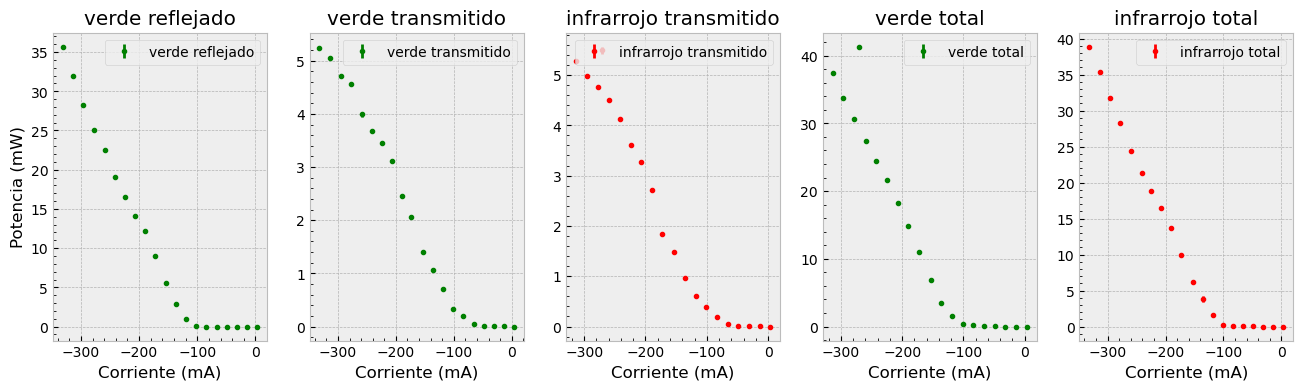

In [16]:
# Definimos listas para las labels y los colores de los graficos
labels = mediciones
marker_color = ["g","g", "r", "g", "r"]

fig, axs = plt.subplots(1,len(labels), figsize=(16,4))
for i, ax in enumerate(fig.axes):
    color = mediciones[i]

    corr_values = dic_pow[f"corr:{color}"]
    POW_values = dic_pow[f"pow:{color}"] 
    POW_var_values = dic_pow[f"sigma:{color}"] 

    ax.errorbar(corr_values, POW_values,yerr = POW_var_values,fmt = f".{marker_color[i]}", label = f"{labels[i]}")
    ax.set_xlabel("Corriente (mA)")
    if i == 0:
        ax.set_ylabel("Potencia (mW)")
    ax.set_title(f"{labels[i]}")
    ax.minorticks_on()
    ax.legend(loc = "upper right")
plt.show()

# Análisis de relaciones entre las potencias

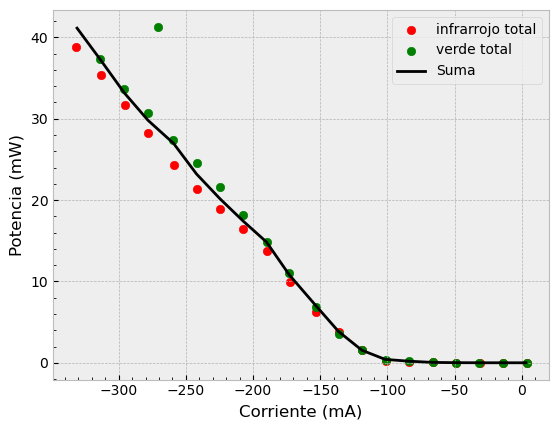

In [102]:
plt.scatter(dic_pow["corr:infrarrojo total"],dic_pow["pow:infrarrojo total"], label = "infrarrojo total", color = "r")
plt.scatter(dic_pow["corr:verde total"],dic_pow["pow:verde total"], label = "verde total", color = "g")

plt.plot(dic_pow["corr:verde reflejado"], dic_pow["pow:verde reflejado"]+dic_pow["pow:infrarrojo transmitido"], label = "Suma", color = "k")

plt.xlabel("Corriente (mA)")
plt.ylabel("Potencia (mW)")
plt.minorticks_on()
plt.legend()
plt.show()

In [69]:
def lineal(x, a, b): return a*np.array(x)+b

def ajuste_lineal(x: np.ndarray, y: np.array, y_err: np.ndarray) -> List[float]:

    popt, pcov = curve_fit(lineal, x,y, sigma = y_err)

    a, b = popt
    err_a, err_b = np.sqrt(np.diag(pcov))

    return a, b, err_a, err_b

In [75]:
a,b, *_ = ajuste_lineal(corr_values, POW_values, POW_var_values)

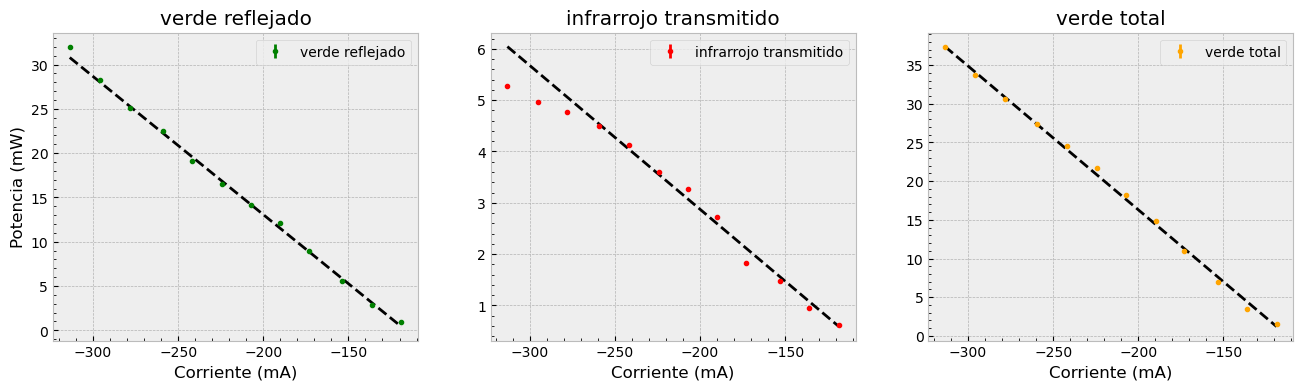

In [95]:
labels = ["verde reflejado", "infrarrojo transmitido", "verde total"]
marker_color = ["g","r", "orange"]

lista_POW_ajuste = []

fig, axs = plt.subplots(1,len(mediciones), figsize=(16,4))
for i, ax in enumerate(fig.axes):
    
    color = labels[i]

    corr_values = dic_pow[f"corr:{color}"][1:13] # Ajustamos el rango en el que se prende el láser
    POW_values = dic_pow[f"pow:{color}"][1:13] 
    POW_var_values = dic_pow[f"sigma:{color}"][1:13] 

    a, b, *_ = ajuste_lineal(corr_values,POW_values, POW_var_values)
    corr_ajuste = np.linspace(min(corr_values), max(corr_values), 1000)
    POW_ajuste = lineal(corr_ajuste,a,b)
    lista_POW_ajuste.append(POW_ajuste)

    ax.errorbar(corr_values, POW_values,yerr = POW_var_values,marker = ".", ls = "", color = f"{marker_color[i]}", label = f"{labels[i]}")
    ax.plot(corr_ajuste, POW_ajuste,color = "k", ls = "--")
    ax.set_xlabel("Corriente (mA)")
    if i == 0:
        ax.set_ylabel("Potencia (mW)")
    ax.set_title(f"{mediciones[i]}")
    ax.minorticks_on()
    ax.legend(loc = "upper right")
plt.show()

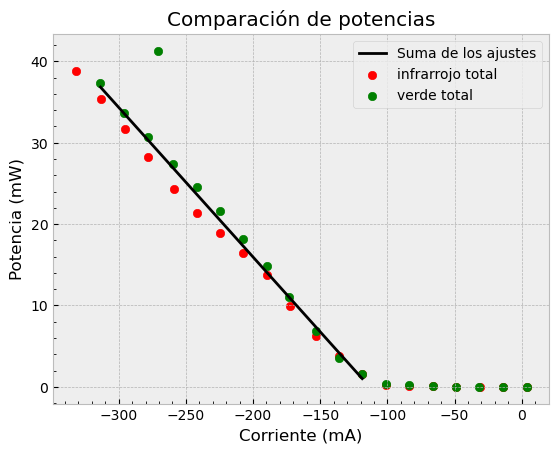

In [99]:
pow_suma = lista_POW_ajuste[0]+lista_POW_ajuste[1]

plt.plot(corr_ajuste, pow_suma, label = "Suma de los ajustes", color = "k")
plt.scatter(dic_pow["corr:infrarrojo total"],dic_pow["pow:infrarrojo total"], label = "infrarrojo total", color = "r")
plt.scatter(dic_pow["corr:verde total"],dic_pow["pow:verde total"], label = "verde total", color = "g")
plt.xlabel("Corriente (mA)")
plt.ylabel("Potencia (mW)")
plt.title("Comparación de potencias")
plt.minorticks_on()
plt.legend()
plt.show()

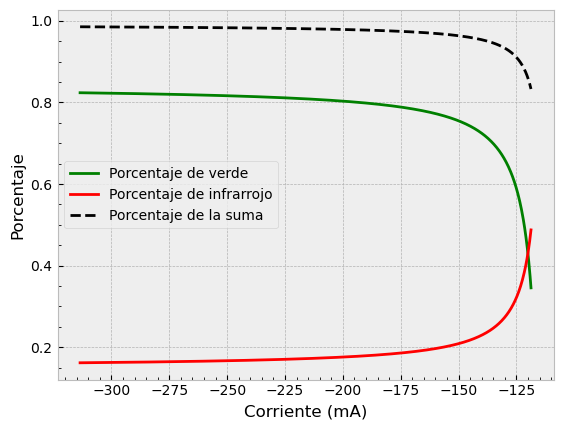

In [100]:
pow_verde, pow_rojo, pow_total = lista_POW_ajuste

plt.plot(corr_ajuste,pow_verde/pow_total, label = "Porcentaje de verde", color = "g")
plt.plot(corr_ajuste,pow_rojo/pow_total, label = "Porcentaje de infrarrojo", color = "r")
plt.plot(corr_ajuste, pow_suma/pow_total, label = "Porcentaje de la suma", color = "k", ls = "--")
plt.xlabel("Corriente (mA)")
plt.ylabel("Porcentaje")
plt.legend()
plt.minorticks_on()
plt.show()

# Potencia de Verde+Rojo contra potencia Total

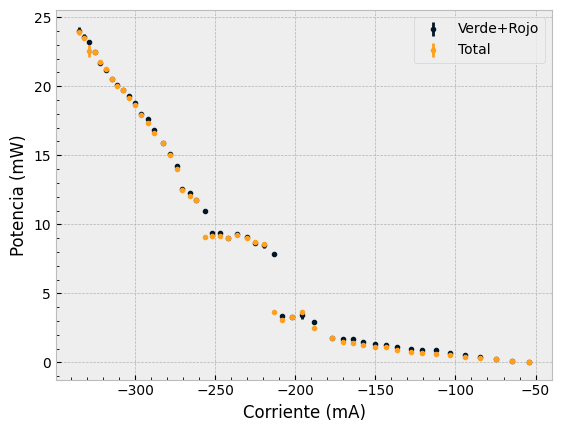

In [24]:
POW_values_suma = dic_pow["pow:rojo"]+dic_pow["pow:verde"]
POW_var_values_suma = dic_pow["sigma:rojo"]+dic_pow["sigma:verde"]

plt.errorbar(corr_values, POW_values_suma, yerr = POW_var_values_suma, fmt = ".", color = "#011627", label = "Verde+Rojo")
plt.errorbar(corr_values, dic_pow["pow:completa"],yerr = dic_pow["sigma:completa"] ,fmt = ".", color = "#FF9F1C", label = "Total")
plt.xlabel("Corriente (mA)")
plt.ylabel("Potencia (mW)")
plt.minorticks_on()
plt.legend()
plt.show()

# Diferencia relativa

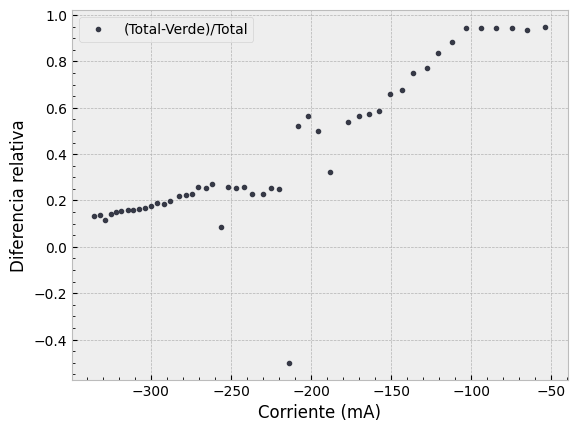

In [29]:
POW_relativa = (dic_pow["pow:completa"]-dic_pow["pow:verde"])/dic_pow["pow:completa"]
plt.plot(corr_values, POW_relativa,".",color = "#363946", label = "(Total-Verde)/Total")
plt.legend()
plt.ylabel("Diferencia relativa")
plt.xlabel("Corriente (mA)")
plt.minorticks_on()
plt.show()

# Total-Verde

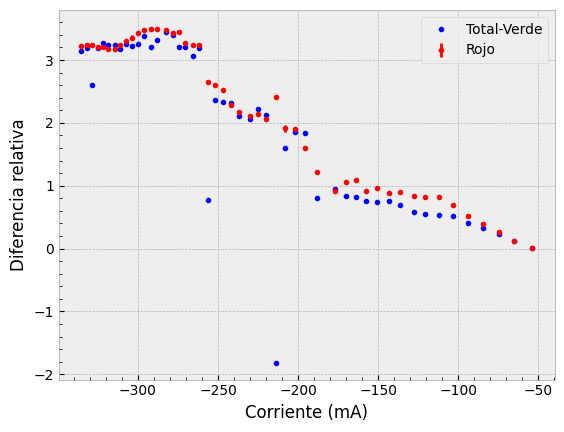

In [31]:
POW_diff = dic_pow["pow:completa"]-dic_pow["pow:verde"]
plt.plot(corr_values, POW_diff,".b", label = "Total-Verde")
plt.errorbar(corr_values, dic_pow["pow:rojo"],yerr = dic_pow["sigma:rojo"],fmt = ".r", label = "Rojo")
plt.legend()
plt.ylabel("Diferencia relativa")
plt.xlabel("Corriente (mA)")
plt.minorticks_on()
plt.show()